# Imports

In [8]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
print(tf.__version__)
# if tf.__version__ < '1.14.0':
#   raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

import pickle

1.12.0


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 107

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [5]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/root/models/research/object_detection/data', 'oid_bbox_trainable_label_map_add2.pbtxt')
NUM_CLASSES = 547

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# read od inference to dictionary

In [25]:
input_dir = '/root/video_inference/od_infrence_1252812627'
od_dict = {}
for folder in sorted(os.listdir(input_dir)):
    input_file = os.path.join(input_dir, folder)
    with open(input_file, 'rb') as handle:
        output_dict = pickle.load(handle)
    od_dict[folder] = output_dict

In [24]:
# od_dict

{'image-000001.pickle': {'detection_boxes': array([[2.27657124e-01, 0.00000000e+00, 8.07455540e-01, 1.00000000e+00],
         [1.22367300e-01, 3.25111896e-02, 5.87794363e-01, 1.00000000e+00],
         [2.12763757e-01, 0.00000000e+00, 8.15154731e-01, 9.89240110e-01],
         [6.52081594e-02, 0.00000000e+00, 9.16295469e-01, 1.00000000e+00],
         [3.75423074e-01, 9.14133713e-02, 9.85507250e-01, 9.79070246e-01],
         [1.26425788e-01, 0.00000000e+00, 9.25530612e-01, 7.19124794e-01],
         [7.01541901e-02, 2.40336619e-02, 9.14988220e-01, 9.81801569e-01],
         [2.38233596e-01, 6.85864761e-02, 5.68482995e-01, 8.69941235e-01],
         [1.20200478e-01, 0.00000000e+00, 5.99289894e-01, 1.00000000e+00],
         [3.47968549e-01, 0.00000000e+00, 9.28800046e-01, 1.00000000e+00],
         [6.04562387e-02, 2.58695483e-02, 8.78907979e-01, 9.61916924e-01],
         [1.81778491e-01, 7.23174065e-02, 8.48291755e-01, 9.79897201e-01],
         [1.19388051e-01, 3.28919999e-02, 8.29369307e-01, 

# get f score, threshold

In [26]:
import pickle

# a = {'hello': 'world'}

with open('/root/openimage/f_score_v5.pickle', 'rb') as handle:
    maxF_dict = pickle.load(handle)


In [35]:
maxF_dict

{1: {'#gt': 21688.0,
  'F_Score': 0.6738373442699064,
  'Name': u'Person',
  'Precision': 0.5804559392081056,
  'Recall': 0.8030247141276282,
  'Threshold': 0.1},
 2: {'#gt': 20118.0,
  'F_Score': 0.6783724156753929,
  'Name': u'Clothing',
  'Precision': 0.6253092372845822,
  'Recall': 0.7412764688338801,
  'Threshold': 0.1},
 3: {'#gt': 11350.0,
  'F_Score': 0.699817556960414,
  'Name': u'Man',
  'Precision': 0.6749324821998527,
  'Recall': 0.7266079295154185,
  'Threshold': 0.30000000000000004},
 4: {'#gt': 9292.0,
  'F_Score': 0.6977084349098001,
  'Name': u'Face',
  'Precision': 0.6378142271349617,
  'Recall': 0.7700172191132156,
  'Threshold': 0.30000000000000004},
 5: {'#gt': 11154.0,
  'F_Score': 0.6615926586352369,
  'Name': u'Tree',
  'Precision': 0.6424529098741448,
  'Recall': 0.6819078357539896,
  'Threshold': 0.2},
 6: {'#gt': 11531.0,
  'F_Score': 0.5574764937822263,
  'Name': u'Plant',
  'Precision': 0.45590342850843346,
  'Recall': 0.7172838435521637,
  'Threshold': 0.1

# filter result though f_score

In [39]:
for key, frame in od_dict.items():

    print frame
    break

{'num_detections': 100, 'detection_boxes': array([[3.98701727e-02, 1.21379094e-02, 8.86285126e-01, 8.26387584e-01],
       [0.00000000e+00, 6.69243395e-01, 1.00000000e+00, 9.97603476e-01],
       [2.91198231e-02, 3.95397209e-02, 9.82864618e-01, 3.50958198e-01],
       [0.00000000e+00, 6.67376637e-01, 9.51813698e-01, 1.00000000e+00],
       [1.10922754e-02, 6.79221749e-01, 9.69785810e-01, 1.00000000e+00],
       [0.00000000e+00, 2.44355470e-01, 8.82539272e-01, 9.99550521e-01],
       [2.01993319e-03, 3.12849164e-01, 5.42657375e-01, 5.44773340e-01],
       [6.65468350e-02, 7.02815473e-01, 9.63987648e-01, 9.99473572e-01],
       [0.00000000e+00, 2.51772441e-02, 9.88329113e-01, 3.47799242e-01],
       [0.00000000e+00, 6.65027559e-01, 9.57572222e-01, 9.98382688e-01],
       [1.12823490e-03, 0.00000000e+00, 9.14329052e-01, 5.30546784e-01],
       [0.00000000e+00, 3.56308103e-01, 5.24214208e-01, 4.96151298e-01],
       [1.90734863e-02, 5.61093807e-01, 5.41670263e-01, 7.59062350e-01],
       [

In [36]:
class_counts = { idx+1:0 for idx in range(NUM_CLASSES)}
for key, frame in od_dict.items():
    for c, prob in zip(frame['detection_classes'], frame['detection_scores']):
        if prob > maxF_dict[c]['Threshold']:
            class_counts[c] += 1
    break

In [37]:
class_counts # tree: 5, > 0.2, correct

{1: 2,
 2: 1,
 3: 0,
 4: 0,
 5: 2,
 6: 0,
 7: 1,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 2,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 1,
 38: 0,
 39: 3,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 7,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 102: 0,
 103: 0,
 104: 0,
 105: 0,
 106: 0,
 107: 0,
 108: 0,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: 0,
 119: 0,
 120: 0,
 121: 0,
 122: 0,
 123: 0,
 

In [40]:
class_counts = { idx+1:0 for idx in range(NUM_CLASSES)}
for key, frame in od_dict.items():
    for c, prob in zip(frame['detection_classes'], frame['detection_scores']):
        if prob > maxF_dict[c]['Threshold']:
            class_counts[c] += 1


In [41]:
class_counts

{1: 3800,
 2: 3592,
 3: 1313,
 4: 2521,
 5: 1563,
 6: 480,
 7: 2583,
 8: 878,
 9: 149,
 10: 12,
 11: 29,
 12: 894,
 13: 378,
 14: 0,
 15: 23,
 16: 34,
 17: 3,
 18: 38,
 19: 77,
 20: 16,
 21: 5,
 22: 131,
 23: 15,
 24: 7,
 25: 2,
 26: 8,
 27: 7,
 28: 250,
 29: 362,
 30: 31,
 31: 2,
 32: 7635,
 33: 0,
 34: 5,
 35: 10,
 36: 0,
 37: 16111,
 38: 6,
 39: 13156,
 40: 0,
 41: 1,
 42: 2,
 43: 0,
 44: 0,
 45: 11931,
 46: 1,
 47: 7601,
 48: 0,
 49: 246,
 50: 1,
 51: 2,
 52: 18,
 53: 2,
 54: 0,
 55: 5393,
 56: 0,
 57: 10,
 58: 3,
 59: 0,
 60: 0,
 61: 6,
 62: 3607,
 63: 2,
 64: 4005,
 65: 1,
 66: 1,
 67: 0,
 68: 30,
 69: 3,
 70: 116,
 71: 2,
 72: 2,
 73: 15,
 74: 0,
 75: 44,
 76: 115,
 77: 0,
 78: 0,
 79: 1,
 80: 0,
 81: 78,
 82: 1,
 83: 1,
 84: 0,
 85: 1,
 86: 1,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 30,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 5,
 101: 0,
 102: 0,
 103: 10,
 104: 23,
 105: 0,
 106: 0,
 107: 0,
 108: 1,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 152,
 11

In [ ]:
## compare

In [51]:
def read_frames_todict(input_dir):
# input_dir = '/root/video_inference/od_infrence_1252812627'
    od_dict = {}
    for folder in sorted(os.listdir(input_dir)):
        input_file = os.path.join(input_dir, folder)
        with open(input_file, 'rb') as handle:
            output_dict = pickle.load(handle)
        od_dict[folder] = output_dict
    return od_dict

In [52]:
def calculate_words(od_dict, NUM_CLASSES, maxF_dict):
    class_counts = { idx+1:0 for idx in range(NUM_CLASSES)}
    for key, frame in od_dict.items():
        for c, prob in zip(frame['detection_classes'], frame['detection_scores']):
            if prob > maxF_dict[c]['Threshold']:
                class_counts[c] += 1
    return class_counts

In [55]:
results = {}

In [56]:
od_dir = 'od_3438636448_1fps' # ah1
results[od_dir] = {}
results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)

In [65]:
for class_idx, count in results[od_dir]['Words'].items():
    print("{0},{1},{2}".format(class_idx,count,category_index[class_idx]['name']))



1,12,Person
2,0,Clothing
3,0,Man
4,0,Face
5,423,Tree
6,3959,Plant
7,0,Woman
8,1604,Vehicle
9,0,Building
10,1,Land vehicle
11,0,Footwear
12,0,Girl
13,2198,Animal
14,0,Car
15,0,Food
16,1,Wheel
17,6,Flower
18,0,Furniture
19,0,Window
20,0,House
21,0,Boy
22,0,Fashion accessory
23,0,Table
24,0,Glasses
25,0,Suit
26,0,Auto part
27,234,Bird
28,168,Sports equipment
29,0,Dress
30,81,Dog
31,48,Carnivore
32,64,Human body
33,0,Jeans
34,0,Musical instrument
35,2,Drink
36,8,Boat
37,77,Hair
38,0,Tire
39,411,Head
40,0,Cat
41,6,Watercraft
42,0,Chair
43,0,Bike
44,0,Tower
45,5536,Mammal
46,0,Skyscraper
47,143,Arm
48,0,Toy
49,0,Sculpture
50,24,Invertebrate
51,0,Microphone
52,3,Poster
53,12,Insect
54,0,Guitar
55,176,Nose
56,0,Hat
57,0,Tableware
58,0,Door
59,0,Bicycle wheel
60,0,Sunglasses
61,0,Baked goods
62,74,Eye
63,0,Dessert
64,118,Mouth
65,1,Aircraft
66,1,Airplane
67,0,Train
68,0,Jacket
69,0,Street light
70,0,Hand
71,0,Snack
72,0,Helmet
73,0,Trousers
74,0,Bottle
75,0,Houseplant
76,148,Horse
77,0,Desk
78,

In [66]:
od_dir = 'od_infrence_1252812627' #g1
results[od_dir] = {}
results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)

In [67]:
for class_idx, count in results[od_dir]['Words'].items():
    print("{0},{1},{2}".format(class_idx,count,category_index[class_idx]['name']))


1,3800,Person
2,3592,Clothing
3,1313,Man
4,2521,Face
5,1563,Tree
6,480,Plant
7,2583,Woman
8,878,Vehicle
9,149,Building
10,12,Land vehicle
11,29,Footwear
12,894,Girl
13,378,Animal
14,0,Car
15,23,Food
16,34,Wheel
17,3,Flower
18,38,Furniture
19,77,Window
20,16,House
21,5,Boy
22,131,Fashion accessory
23,15,Table
24,7,Glasses
25,2,Suit
26,8,Auto part
27,7,Bird
28,250,Sports equipment
29,362,Dress
30,31,Dog
31,2,Carnivore
32,7635,Human body
33,0,Jeans
34,5,Musical instrument
35,10,Drink
36,0,Boat
37,16111,Hair
38,6,Tire
39,13156,Head
40,0,Cat
41,1,Watercraft
42,2,Chair
43,0,Bike
44,0,Tower
45,11931,Mammal
46,1,Skyscraper
47,7601,Arm
48,0,Toy
49,246,Sculpture
50,1,Invertebrate
51,2,Microphone
52,18,Poster
53,2,Insect
54,0,Guitar
55,5393,Nose
56,0,Hat
57,10,Tableware
58,3,Door
59,0,Bicycle wheel
60,0,Sunglasses
61,6,Baked goods
62,3607,Eye
63,2,Dessert
64,4005,Mouth
65,1,Aircraft
66,1,Airplane
67,0,Train
68,30,Jacket
69,3,Street light
70,116,Hand
71,2,Snack
72,2,Helmet
73,15,Trousers
74,0,Bott

# plot figure

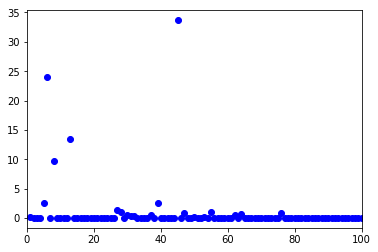

In [78]:
od_dir = 'od_3438636448_1fps' #ah1
results[od_dir]['Words']
total_cnt = 0
for cnt in results[od_dir]['Words'].values():
    total_cnt += cnt
xx = [x+1 for x in range(NUM_CLASSES)]
yy = [results[od_dir]['Words'][x+1]*100.0/total_cnt   for x in range(NUM_CLASSES)  ]
plt.xlim(0, 100);
# plt.ylim(0, 1.0);
plt.plot(xx, yy, 'ob');

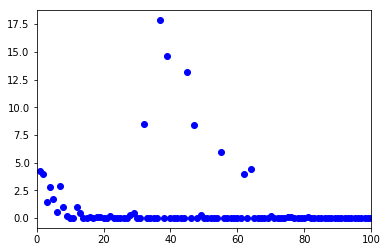

In [108]:
od_dir = 'od_infrence_1252812627'  # g1
results[od_dir]['Words']
total_cnt = 0
for cnt in results[od_dir]['Words'].values():
    total_cnt += cnt
xx = [x+1 for x in range(NUM_CLASSES)]
yy = [results[od_dir]['Words'][x+1]*100.0/total_cnt   for x in range(NUM_CLASSES)  ]
plt.xlim(0, 100);
# plt.ylim(0, 1.0);
plt.plot(xx, yy, 'ob');

In [165]:
def plot_class(od_dir, results, NUM_CLASSES, topN=5, out_path=''):
    results[od_dir]['Words']
    total_cnt = 0
#     for cnt in results[od_dir]['Words'].values():
#         total_cnt += cnt
    total_cnt = sum(results[od_dir]['Words'].values())
    xx = [x+1 for x in range(NUM_CLASSES)]
    yy = [results[od_dir]['Words'][x+1]*100.0/total_cnt   for x in range(NUM_CLASSES)  ]
    plt.xlim(0, 547);
    # plt.ylim(0, 1.0);
    plt.plot(xx, yy, 'ob');
    print_topN(od_dir, results, topN)
    if out_path:
        plt.savefig(out_path, transparent=False, dpi = 300)

# print top words

In [90]:
od_dir = 'od_infrence_1252812627'  # g1
results[od_dir]['Words']

{1: 3800,
 2: 3592,
 3: 1313,
 4: 2521,
 5: 1563,
 6: 480,
 7: 2583,
 8: 878,
 9: 149,
 10: 12,
 11: 29,
 12: 894,
 13: 378,
 14: 0,
 15: 23,
 16: 34,
 17: 3,
 18: 38,
 19: 77,
 20: 16,
 21: 5,
 22: 131,
 23: 15,
 24: 7,
 25: 2,
 26: 8,
 27: 7,
 28: 250,
 29: 362,
 30: 31,
 31: 2,
 32: 7635,
 33: 0,
 34: 5,
 35: 10,
 36: 0,
 37: 16111,
 38: 6,
 39: 13156,
 40: 0,
 41: 1,
 42: 2,
 43: 0,
 44: 0,
 45: 11931,
 46: 1,
 47: 7601,
 48: 0,
 49: 246,
 50: 1,
 51: 2,
 52: 18,
 53: 2,
 54: 0,
 55: 5393,
 56: 0,
 57: 10,
 58: 3,
 59: 0,
 60: 0,
 61: 6,
 62: 3607,
 63: 2,
 64: 4005,
 65: 1,
 66: 1,
 67: 0,
 68: 30,
 69: 3,
 70: 116,
 71: 2,
 72: 2,
 73: 15,
 74: 0,
 75: 44,
 76: 115,
 77: 0,
 78: 0,
 79: 1,
 80: 0,
 81: 78,
 82: 1,
 83: 1,
 84: 0,
 85: 1,
 86: 1,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 30,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 5,
 101: 0,
 102: 0,
 103: 10,
 104: 23,
 105: 0,
 106: 0,
 107: 0,
 108: 1,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 152,
 11

In [91]:
numbers=results[od_dir]['Words']
sorted(numbers, key=numbers.__getitem__, reverse=True)

[37,
 39,
 45,
 32,
 47,
 55,
 64,
 1,
 62,
 2,
 7,
 4,
 5,
 3,
 12,
 8,
 6,
 13,
 29,
 184,
 28,
 49,
 113,
 9,
 22,
 70,
 76,
 81,
 19,
 75,
 18,
 16,
 30,
 68,
 91,
 11,
 127,
 408,
 128,
 150,
 15,
 104,
 183,
 434,
 175,
 52,
 20,
 221,
 23,
 73,
 153,
 236,
 10,
 165,
 314,
 35,
 57,
 103,
 431,
 26,
 119,
 24,
 27,
 143,
 194,
 335,
 38,
 61,
 116,
 182,
 283,
 328,
 379,
 21,
 34,
 100,
 254,
 198,
 203,
 216,
 325,
 385,
 438,
 17,
 58,
 69,
 187,
 374,
 392,
 501,
 25,
 31,
 42,
 51,
 53,
 63,
 71,
 72,
 142,
 208,
 281,
 332,
 334,
 413,
 416,
 449,
 525,
 544,
 41,
 46,
 50,
 65,
 66,
 79,
 82,
 83,
 85,
 86,
 108,
 129,
 138,
 145,
 205,
 225,
 233,
 238,
 260,
 274,
 299,
 316,
 353,
 364,
 373,
 398,
 421,
 427,
 439,
 457,
 496,
 517,
 524,
 14,
 33,
 36,
 40,
 43,
 44,
 48,
 54,
 56,
 59,
 60,
 67,
 74,
 77,
 78,
 80,
 84,
 87,
 88,
 89,
 90,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 101,
 102,
 105,
 106,
 107,
 109,
 110,
 111,
 112,
 114,
 115,
 117,
 118,
 120,
 121

In [104]:
wordsFreqDict=results[od_dir]['Words']
# Create a list of tuples sorted by index 1 i.e. value field     
listofTuples = sorted(wordsFreqDict.items() ,  key=lambda x: x[1], reverse=True)
# Iterate over the sorted sequence
total_cnt = sum(results[od_dir]['Words'].values())
print('ID', 'frequency', 'Name' )
for elem in listofTuples[0:5] :
    print(elem[0] , elem[1]*100.0/total_cnt, category_index[elem[0]]['name'] )

('ID', 'frequency', 'Name')
(37, 17.85152354570637, u'Hair')
(39, 14.577285318559557, u'Head')
(45, 13.21994459833795, u'Mammal')
(32, 8.45983379501385, u'Human body')
(47, 8.422160664819945, u'Arm')


In [158]:
def print_topN(od_dir, results, topN=5):
    wordsFreqDict=results[od_dir]['Words']
    # Create a list of tuples sorted by index 1 i.e. value field     
    listofTuples = sorted(wordsFreqDict.items() ,  key=lambda x: x[1], reverse=True)
    # Iterate over the sorted sequence
    total_cnt = sum(results[od_dir]['Words'].values())
#     print('ID', 'frequency', 'Name' )
    print("{0},{1},{2}".format('ID', 'frequency (%)', 'Name' ))
    for elem in listofTuples[0:topN] :
#         print(elem[0] , elem[1]*100.0/total_cnt, category_index[elem[0]]['name'] )
        print("{0},{1:0.2f},{2}".format(elem[0] , elem[1]*100.0/total_cnt, category_index[elem[0]]['name']))



('ID', 'frequency', 'Name')
(37, 17.85152354570637, u'Hair')
(39, 14.577285318559557, u'Head')
(45, 13.21994459833795, u'Mammal')
(32, 8.45983379501385, u'Human body')
(47, 8.422160664819945, u'Arm')


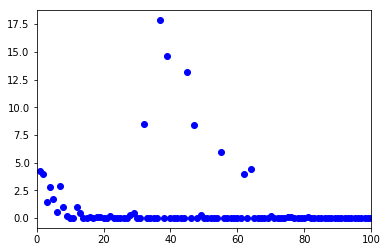

In [109]:
od_dir = 'od_infrence_1252812627'  # g1
plot_class(od_dir, results, NUM_CLASSES)

('ID', 'frequency', 'Name')
(45, 33.67601435610439, u'Mammal')
(6, 24.082973416874506, u'Plant')
(13, 13.370642983149827, u'Animal')
(8, 9.757284506356834, u'Vehicle')
(5, 2.5731492183222824, u'Tree')


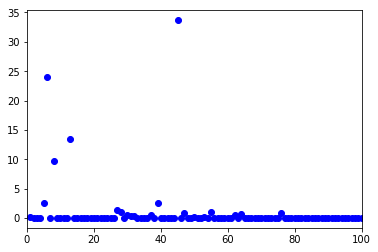

In [110]:
od_dir = 'od_3438636448_1fps' #ah1
plot_class(od_dir, results, NUM_CLASSES)

# compare...

('ID', 'frequency', 'Name')
37,18.42,Hair
39,14.59,Head
45,11.20,Mammal
47,9.02,Arm
55,8.57,Nose


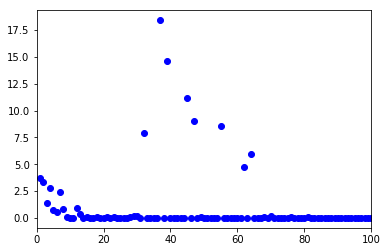

In [154]:
od_dir = 'od_3438636448_1fps' #ah1
od_dir = 'od_infrence_1252812627' #g1
od_dir = 'od_infrence_1252812923' #g2
results[od_dir] = {}
results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)
plot_class(od_dir, results, NUM_CLASSES)

('ID', 'frequency', 'Name')
(45, 27.28497092133456, u'Mammal')
(6, 22.626262626262626, u'Plant')
(5, 15.86164677073768, u'Tree')
(13, 6.5381083562901745, u'Animal')
(39, 3.783287419651056, u'Head')


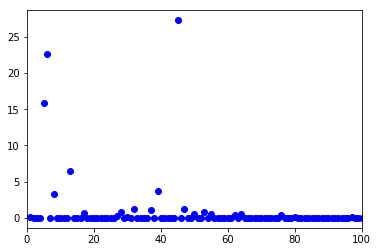

In [112]:
od_dir = 'od_3438636448_1fps' #ah1
od_dir = 'od_infrence_1252812627' #g1
od_dir = 'od_infrence_1252812923' #g2
od_dir = 'od_3477876483_1fps' #aw1
results[od_dir] = {}
results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)
plot_class(od_dir, results, NUM_CLASSES)

('ID', 'frequency', 'Name')
(37, 16.534126270659012, u'Hair')
(47, 13.89253855196736, u'Arm')
(32, 9.757278196528594, u'Human body')
(39, 9.556738814743102, u'Head')
(2, 8.744208560957057, u'Clothing')
(45, 5.708457229790471, u'Mammal')
(1, 4.8578936449761425, u'Person')
(7, 4.321969435032155, u'Woman')
(4, 3.5059816056980844, u'Face')
(3, 3.43683009473757, u'Man')
(8, 2.4825392434824702, u'Vehicle')
(12, 1.3830302192102897, u'Girl')
(23, 1.1963211396169007, u'Table')
(103, 1.054560542147846, u'Couch')
(55, 0.8713090381024825, u'Nose')
(62, 0.8471060092663024, u'Eye')
(24, 0.8332757070741996, u'Glasses')
(64, 0.7502938939215822, u'Mouth')
(18, 0.7364635917294793, u'Furniture')
(35, 0.6016181453564761, u'Drink')


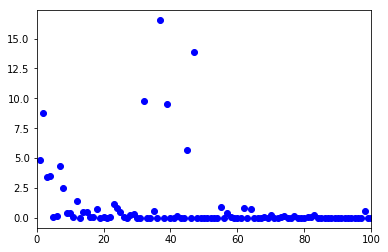

In [146]:
od_dir = 'od_3438636448_1fps' #ah1
od_dir = 'od_infrence_1252812627' #g1
od_dir = 'od_infrence_1252812923' #g2
od_dir = 'od_3477876483_1fps' #aw1
od_dir = 'od_3423612893_1fps' #b1
results[od_dir] = {}
results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)
plot_class(od_dir, results, NUM_CLASSES,20)

('ID', 'frequency', 'Name')
(47, 19.92185255415733, u'Arm')
(37, 13.739010515428374, u'Hair')
(32, 11.500890651037178, u'Human body')
(2, 11.098661150376373, u'Clothing')
(39, 7.79463310923404, u'Head')
(45, 5.4444635982301905, u'Mammal')
(7, 5.269206458656553, u'Woman')
(1, 4.071137160259726, u'Person')
(3, 3.1115324943975176, u'Man')
(4, 2.9276561512382924, u'Face')
(12, 2.3300580359708096, u'Girl')
(23, 1.7468252600126415, u'Table')
(29, 1.2785151985289893, u'Dress')
(18, 1.1348618054358444, u'Furniture')
(103, 0.7441245762224904, u'Couch')
(55, 0.6751709475377808, u'Nose')
(9, 0.6062173188530713, u'Building')
(57, 0.5774866402344423, u'Tableware')
(8, 0.5746135723725795, u'Vehicle')
(77, 0.32178360052864446, u'Desk')


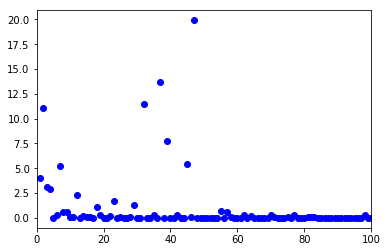

In [144]:
od_dir = 'od_3438636448_1fps' #ah1
od_dir = 'od_infrence_1252812627' #g1
od_dir = 'od_infrence_1252812923' #g2
od_dir = 'od_3477876483_1fps' #aw1
od_dir = 'od_169182094_1fps' #f1
results[od_dir] = {}
results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)
plot_class(od_dir, results, NUM_CLASSES,20)

In [141]:
od_dir = 'od_169182094_1fps' #f1
ID = [118, 89]
printClass(od_dir, results, ID, category_index)

(118, 0, u'Football')
(89, 0, u'Ball')


('ID', 'frequency', 'Name')
(47, 20.420392735318522, u'Arm')
(37, 15.273040164715283, u'Hair')
(32, 10.211732890814664, u'Human body')
(2, 8.964076088626655, u'Clothing')
(39, 8.67828278172152, u'Head')
(45, 5.522264220521803, u'Mammal')
(7, 4.8554131710764885, u'Woman')
(1, 3.868965305307151, u'Person')
(12, 3.0269506161457853, u'Girl')
(3, 2.821056513321656, u'Man')
(4, 2.6090163178759105, u'Face')
(23, 1.757782489782121, u'Table')
(29, 1.2937524968501275, u'Dress')
(18, 0.9772287268369134, u'Furniture')
(103, 0.9464982637288344, u'Couch')
(55, 0.9342060784856028, u'Nose')
(6, 0.6176823084723887, u'Plant')
(62, 0.5254909191481516, u'Eye')
(64, 0.4578839003103777, u'Mouth')
(9, 0.4548108539995698, u'Building')


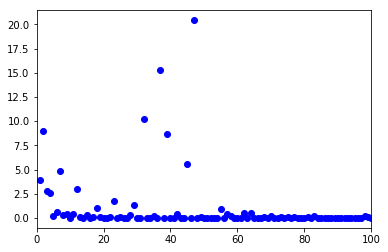

In [123]:
od_dir = 'od_169182098_1fps' #f2
results[od_dir] = {}
results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)
plot_class(od_dir, results, NUM_CLASSES,20)

('ID', 'frequency', 'Name')
(47, 20.070080113610054, u'Arm')
(37, 14.27226278498989, u'Hair')
(39, 8.772363119954308, u'Head')
(32, 7.875522899526111, u'Human body')
(55, 6.098822221879197, u'Nose')
(2, 5.55546979917571, u'Clothing')
(45, 5.1973511569393205, u'Mammal')
(62, 5.036815213867835, u'Eye')
(64, 4.8129910624700925, u'Mouth')
(1, 3.3326644335705353, u'Person')
(8, 3.136625349242857, u'Vehicle')
(4, 3.0810552151027277, u'Face')
(7, 2.543877251748144, u'Woman')
(12, 1.8338144266242686, u'Girl')
(3, 0.8798604572187148, u'Man')
(5, 0.7254989734961332, u'Tree')
(19, 0.5803991787969066, u'Window')
(70, 0.5356343485173579, u'Hand')
(14, 0.5047620517728416, u'Car')
(28, 0.4630844511677446, u'Sports equipment')


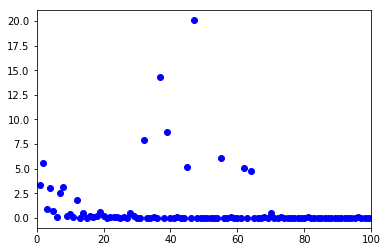

In [121]:
od_dir = 'od_3497684122_1fps' #p1
results[od_dir] = {}
results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)
plot_class(od_dir, results, NUM_CLASSES, 20)

In [140]:
od_dir = 'od_3497684122_1fps' #p1
ID = [118, 89]
printClass(od_dir, results, ID, category_index)

(118, 0, u'Football')
(89, 0, u'Ball')


ID,frequency (%),Name
47,23.89,Arm
37,13.63,Hair
39,9.71,Head
32,8.47,Human body
2,6.01,Clothing
45,5.47,Mammal
1,3.55,Person
4,3.09,Face
55,3.06,Nose
64,2.76,Mouth
3,2.15,Man
7,2.11,Woman
62,1.94,Eye
8,1.85,Vehicle
12,1.67,Girl
24,0.67,Glasses
70,0.57,Hand
6,0.53,Plant
28,0.51,Sports equipment
22,0.44,Fashion accessory


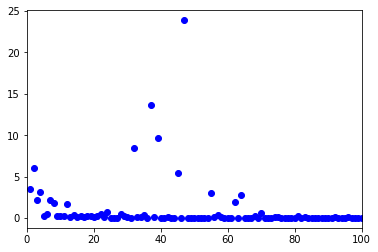

In [159]:
od_dir = 'od_3498539801_1fps' #t1
results[od_dir] = {}
results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)
plot_class(od_dir, results, NUM_CLASSES, 20)

In [139]:
od_dir = 'od_3498539801_1fps' #t1
ID = [118, 89]
printClass(od_dir, results, ID, category_index)

(118, 0, u'Football')
(89, 2, u'Ball')


('ID', 'frequency', 'Name')
(47, 20.352350602704977, u'Arm')
(37, 14.546985409317147, u'Hair')
(39, 9.293700107644922, u'Head')
(32, 8.576422564933335, u'Human body')
(2, 5.892760079721189, u'Clothing')
(45, 4.985771686188411, u'Mammal')
(55, 3.7014931736067442, u'Nose')
(8, 3.502190201114818, u'Vehicle')
(62, 3.433979558122928, u'Eye')
(1, 3.413729523484711, u'Person')
(4, 3.0833342214927475, u'Face')
(64, 2.8552548839886174, u'Mouth')
(7, 2.5600306947893463, u'Woman')
(12, 1.987700768435525, u'Girl')
(3, 1.6445159708825818, u'Man')
(14, 0.6128299956302556, u'Car')
(10, 0.5733957176505696, u'Land vehicle')
(57, 0.5062508659554286, u'Tableware')
(35, 0.5051850746586803, u'Drink')
(70, 0.4870666226139597, u'Hand')
(118, 0, u'Football')
(89, 0, u'Ball')


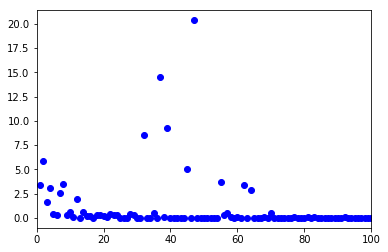

In [145]:
od_dir = 'od_3498532459_1fps' #t2
results[od_dir] = {}
results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)
plot_class(od_dir, results, NUM_CLASSES, 20)
ID = [118, 89]
printClass(od_dir, results, ID, category_index)

('ID', 'frequency', 'Name')
(47, 14.763679737587594, u'Arm')
(39, 11.259877739674966, u'Head')
(37, 10.335470404055464, u'Hair')
(45, 10.201282242433278, u'Mammal')
(1, 8.752050096913672, u'Person')
(32, 7.905173699120322, u'Human body')
(2, 5.922170866259132, u'Clothing')
(28, 5.0961681824959, u'Sports equipment')
(55, 4.1091397047860445, u'Nose')
(64, 3.5127478753541075, u'Mouth')
(62, 3.3994334277620397, u'Eye')
(3, 3.02072461607276, u'Man')
(4, 2.5436111525272103, u'Face')
(8, 1.3806470851349337, u'Vehicle')
(113, 0.7693454599671985, u'Ear')
(7, 0.7365439093484419, u'Woman')
(6, 0.632175339197853, u'Plant')
(180, 0.6172655434620545, u'Football helmet')
(184, 0.5725361562546593, u'Beard')
(96, 0.5218428507529447, u'Sports uniform')


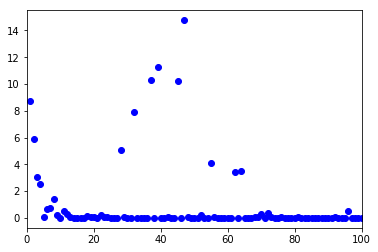

In [125]:
od_dir = 'od_3491078546_1fps' #fo1
results[od_dir] = {}
results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)
plot_class(od_dir, results, NUM_CLASSES, 20)

In [138]:
od_dir = 'od_3491078546_1fps' #fo1
ID = [118, 89]
printClass(od_dir, results, ID, category_index)

(118, 0, u'Football')
(89, 5, u'Ball')


('ID', 'frequency', 'Name')
(47, 14.774020986214937, u'Arm')
(45, 10.604210959467801, u'Mammal')
(39, 10.48624922844798, u'Head')
(2, 9.441053425690967, u'Clothing')
(1, 8.648240861394966, u'Person')
(32, 8.397229270969069, u'Human body')
(37, 8.187367121596598, u'Hair')
(3, 4.75687538577601, u'Man')
(28, 3.420890199574789, u'Sports equipment')
(4, 2.364721212536863, u'Face')
(55, 2.351004732185721, u'Nose')
(8, 2.308483643097181, u'Vehicle')
(64, 1.3538166106577052, u'Mouth')
(7, 1.1124065564776078, u'Woman')
(5, 0.8874562787188808, u'Tree')
(11, 0.881969686578424, u'Footwear')
(62, 0.8696248542623962, u'Eye')
(96, 0.8545367258761402, u'Sports uniform')
(9, 0.7173719223647212, u'Building')
(72, 0.6556477607845826, u'Helmet')


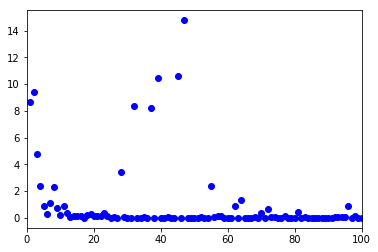

In [126]:
od_dir = 'od_3582306776_1fps' #c1
results[od_dir] = {}
results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)
plot_class(od_dir, results, NUM_CLASSES, 20)

In [136]:
results[od_dir]['Words'][89]
def printClass(od_dir, results, IDs, category_index):
    for ID in IDs:
        print(ID , results[od_dir]['Words'][ID], category_index[ID]['name'] )

In [137]:
od_dir = 'od_3582306776_1fps' #c1
ID = [118, 89]
printClass(od_dir, results, ID, category_index)

(118, 6, u'Football')
(89, 17, u'Ball')


('ID', 'frequency', 'Name')
(37, 20.710147250784345, u'Hair')
(39, 14.925458584285616, u'Head')
(47, 11.662124716605216, u'Arm')
(32, 10.680834497446584, u'Human body')
(45, 8.46291249685117, u'Mammal')
(55, 6.253005702246548, u'Nose')
(64, 4.522866237662308, u'Mouth')
(2, 4.04195387821467, u'Clothing')
(1, 3.849588934435615, u'Person')
(62, 3.7992076396363386, u'Eye')
(4, 2.8820390684040578, u'Face')
(7, 2.7618109785421487, u'Woman')
(3, 1.3419744887443608, u'Man')
(22, 0.6034305081640599, u'Fashion accessory')
(29, 0.5301486248196579, u'Dress')
(12, 0.5290035953924016, u'Girl')
(113, 0.38243982870359766, u'Ear')
(8, 0.310302974786452, u'Vehicle')
(5, 0.22671582659674352, u'Tree')
(28, 0.2175555911786933, u'Sports equipment')
(118, 0, u'Football')
(89, 0, u'Ball')


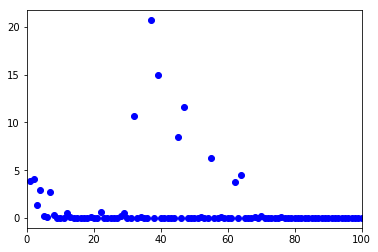

In [142]:
od_dir = 'od_3468314939_1fps' #ca1
results[od_dir] = {}
results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)
plot_class(od_dir, results, NUM_CLASSES, 20)
ID = [118, 89]
printClass(od_dir, results, ID, category_index)

('ID', 'frequency', 'Name')
(37, 17.85152354570637, u'Hair')
(39, 14.577285318559557, u'Head')
(45, 13.21994459833795, u'Mammal')
(32, 8.45983379501385, u'Human body')
(47, 8.422160664819945, u'Arm')
(55, 5.975623268698061, u'Nose')
(64, 4.437673130193906, u'Mouth')
(1, 4.2105263157894735, u'Person')
(62, 3.9966759002770083, u'Eye')
(2, 3.98005540166205, u'Clothing')
(7, 2.8620498614958447, u'Woman')
(4, 2.7933518005540168, u'Face')
(5, 1.7318559556786703, u'Tree')
(3, 1.4548476454293628, u'Man')
(12, 0.9905817174515236, u'Girl')
(8, 0.9728531855955679, u'Vehicle')
(6, 0.5318559556786704, u'Plant')
(13, 0.4188365650969529, u'Animal')
(29, 0.40110803324099725, u'Dress')
(184, 0.2969529085872576, u'Beard')
(118, 0, u'Football')
(89, 0, u'Ball')


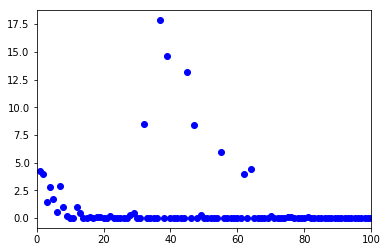

In [147]:
od_dir = 'od_infrence_1252812627' #g1
results[od_dir] = {}
results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)
plot_class(od_dir, results, NUM_CLASSES, 20)
ID = [118, 89]
printClass(od_dir, results, ID, category_index)

('ID', 'frequency', 'Name')
(37, 18.417297771924048, u'Hair')
(39, 14.587860827571069, u'Head')
(45, 11.20074635056525, u'Mammal')
(47, 9.022061244649326, u'Arm')
(55, 8.566567884974207, u'Nose')
(32, 7.894852376248491, u'Human body')
(64, 5.924706398858523, u'Mouth')
(62, 4.7239600482932715, u'Eye')
(1, 3.740533421139282, u'Person')
(2, 3.3179672922840524, u'Clothing')
(4, 2.7933267478871695, u'Face')
(7, 2.3861266600812203, u'Woman')
(3, 1.3533091866973987, u'Man')
(12, 0.9219624629568653, u'Girl')
(8, 0.793546262759302, u'Vehicle')
(5, 0.7836680935133356, u'Tree')
(6, 0.5959828778399736, u'Plant')
(13, 0.38524860059269017, u'Animal')
(184, 0.30841839534628473, u'Beard')
(113, 0.2326857644605422, u'Ear')
(118, 0, u'Football')
(89, 0, u'Ball')


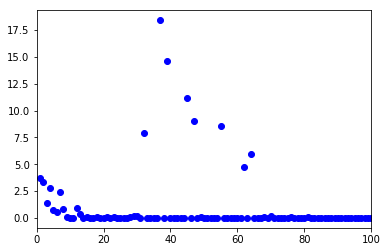

In [148]:
od_dir = 'od_infrence_1252812923' #g2
results[od_dir] = {}
results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)
plot_class(od_dir, results, NUM_CLASSES, 20)
ID = [118, 89]
printClass(od_dir, results, ID, category_index)

('ID', 'frequency', 'Name')
(47, 17.82179780601373, u'Arm')
(37, 10.573751085155079, u'Hair')
(39, 9.865046168416068, u'Head')
(32, 8.908531291926446, u'Human body')
(55, 7.427985162970563, u'Nose')
(8, 5.519690632152159, u'Vehicle')
(45, 5.508641780443533, u'Mammal')
(2, 4.882014047825744, u'Clothing')
(1, 4.763633493804751, u'Person')
(64, 3.8970878383710836, u'Mouth')
(62, 3.4140951779654327, u'Eye')
(3, 3.027385368163523, u'Man')
(4, 2.566490411175124, u'Face')
(9, 1.180648725436035, u'Building')
(113, 0.8333991003077894, u'Ear')
(10, 0.8270854707600032, u'Land vehicle')
(7, 0.8160366190513771, u'Woman')
(14, 0.6250493252308421, u'Car')
(18, 0.5350801041748875, u'Furniture')
(24, 0.4814142530187041, u'Glasses')
(118, 0, u'Football')
(89, 0, u'Ball')


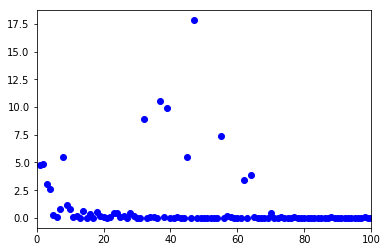

In [149]:
od_dir = 'od_942334491_1fps' #b1
results[od_dir] = {}
results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)
plot_class(od_dir, results, NUM_CLASSES, 20)
ID = [118, 89]
printClass(od_dir, results, ID, category_index)

ID,frequency,Name
47,16.15,Arm
37,15.23,Hair
39,10.68,Head
32,8.71,Human body
45,6.15,Mammal
55,6.06,Nose
2,5.85,Clothing
1,4.63,Person
62,3.03,Eye
3,2.79,Man
64,2.77,Mouth
4,2.55,Face
8,2.29,Vehicle
7,1.93,Woman
5,1.07,Tree
23,0.94,Table
18,0.73,Furniture
12,0.73,Girl
9,0.58,Building
57,0.50,Tableware
(118, 0, u'Football')
(89, 0, u'Ball')


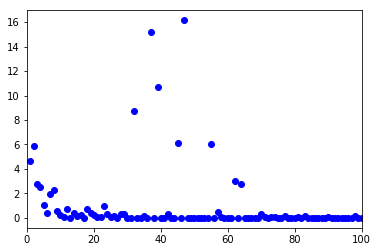

In [157]:
od_dir = 'od_942334494_1fps' #b2
results[od_dir] = {}
results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)
plot_class(od_dir, results, NUM_CLASSES, 20)
ID = [118, 89]
printClass(od_dir, results, ID, category_index)

ID,frequency (%),Name
47,14.76,Arm
39,11.26,Head
37,10.34,Hair
45,10.20,Mammal
1,8.75,Person
32,7.91,Human body
2,5.92,Clothing
28,5.10,Sports equipment
55,4.11,Nose
64,3.51,Mouth
62,3.40,Eye
3,3.02,Man
4,2.54,Face
8,1.38,Vehicle
113,0.77,Ear
7,0.74,Woman
6,0.63,Plant
180,0.62,Football helmet
184,0.57,Beard
96,0.52,Sports uniform
(118, 0, u'Football')
(89, 5, u'Ball')


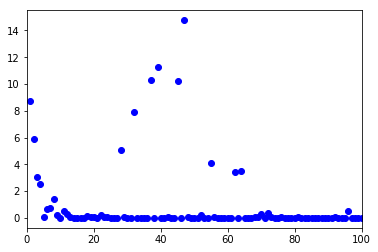

In [203]:
od_dir = 'od_3491078546_1fps' 
# results[od_dir] = {}
# results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
# results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)
plot_class(od_dir, results, NUM_CLASSES, 20,'/root/ampvideo_fig/'+od_dir+'.png')
ID = [118, 89]
printClass(od_dir, results, ID, category_index)


In [ ]:
# calculate all most frequent classes

In [184]:
videos = ['od_infrence_1252812627','od_infrence_1252812923','od_169182094_1fps','od_169182098_1fps','od_279703428_1fps','od_279703885_1fps','od_942334491_1fps','od_942334494_1fps','od_3438636448_1fps','od_3477876483_1fps','od_3423612893_1fps','od_3497684122_1fps','od_3498539801_1fps','od_3498532459_1fps','od_3491078546_1fps','od_3582306776_1fps','od_3582306776_1fps']

In [ ]:
def print_topN(od_dir, results, topN=5):
    wordsFreqDict=results[od_dir]['Words']
    # Create a list of tuples sorted by index 1 i.e. value field     
    listofTuples = sorted(wordsFreqDict.items() ,  key=lambda x: x[1], reverse=True)
    # Iterate over the sorted sequence
    total_cnt = sum(results[od_dir]['Words'].values())
#     print('ID', 'frequency', 'Name' )
    print("{0},{1},{2}".format('ID', 'frequency (%)', 'Name' ))
    for elem in listofTuples[0:topN] :
#         print(elem[0] , elem[1]*100.0/total_cnt, category_index[elem[0]]['name'] )
        print("{0},{1:0.2f},{2}".format(elem[0] , elem[1]*100.0/total_cnt, category_index[elem[0]]['name']))




In [186]:
most_classes = set()
for od_dir in videos:
    if od_dir not in results:
        results[od_dir] = {}
        results[od_dir]['Raw'] = read_frames_todict('/root/ampvideo_inference/'+od_dir)
        results[od_dir]['Words'] = calculate_words(results[od_dir]['Raw'], NUM_CLASSES, maxF_dict)
    wordsFreqDict=results[od_dir]['Words']
    # Create a list of tuples sorted by index 1 i.e. value field     
    listofTuples = sorted(wordsFreqDict.items() ,  key=lambda x: x[1], reverse=True)
    for elem in listofTuples[0:20] :
        most_classes.add(elem[0])

In [188]:
most_classes.add(118)
most_classes.add(89)

In [189]:
def plot_class_most(od_dir, results, NUM_CLASSES, topN=5, out_path='',most_classes=set()):
    results[od_dir]['Words']
    total_cnt = 0
#     for cnt in results[od_dir]['Words'].values():
#         total_cnt += cnt
    total_cnt = sum(results[od_dir]['Words'].values())
    xx = [x+1 for x in range(NUM_CLASSES)]
    yy = [results[od_dir]['Words'][x+1]*100.0/total_cnt   for x in range(NUM_CLASSES)  ]
    plt.xlim(0, 100);
    # plt.ylim(0, 1.0);
    plt.plot(xx, yy, 'ob');
    print_topN(od_dir, results, topN)
    if out_path:
        plt.savefig(out_path, transparent=False, dpi = 300)
        